## This notebook finds the best fit Gaussian parameters for each absorption feature detected in the median spectrum of 51 Pegasi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
Features = pd.read_csv("Features.csv")

In [3]:
Template = pd.read_csv("medianspec.csv")

In [4]:
%matplotlib notebook

In [5]:
def gaussfunc(x, mu, sigma):
    return np.exp(1)**(-((x - mu)**2)/(2*(sigma**2)))
def gauss1func(x, a1, mu1, sig1):
    return 1 - a1*gaussfunc(x, mu1, sig1)
def gauss2func(x, a1, a2, mu1, mu2, sig1, sig2):
    return 1 - a1*gaussfunc(x, mu1, sig1) - a2*gaussfunc(x, mu2, sig2)
def gauss3func(x, a1, a2, a3, mu1, mu2, mu3, sig1, sig2, sig3):
    return 1 - a1*gaussfunc(x, mu1, sig1) - a2*gaussfunc(x, mu2, sig2) - a3*gaussfunc(x, mu3, sig3)

In [10]:
#WARNING: This cell takes about 30 minutes to run on a laptop, but could be easily parallelized. This cell goes through each
          #absorption features and fits a Gaussian to it, together with its two neighboring features. If the non-linear
          #optimization algorithm doesn't converge, we try fitting with just one of its neighbors. If convergence still isn't
          #reached, we just try fitting it alone, otherwise we set the amplitude to be zero. The fitted parameters are already
          #contained in the Features.csv file that is read in above, so this cell doesn't need to be run.
amps = []
mus = []
sigs = []
for i in range(1,len(Features.Wv_lbounds)-1):
    #print(i)
    w = np.where((Template.Wavelength >= Features.Wv_lbounds[i-1]) & (Template.Wavelength <= Features.Wv_ubounds[i-1]))[0]
    a1_0 = 1 - np.min(Template.Flux[w])
    mu1_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
    sig1_0 = (Features.Wv_ubounds[i-1] - Features.Wv_lbounds[i-1])/5
    w = np.where((Template.Wavelength >= Features.Wv_lbounds[i]) & (Template.Wavelength <= Features.Wv_ubounds[i]))[0]
    a2_0 = 1 - np.min(Template.Flux[w])
    mu2_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
    sig2_0 = (Features.Wv_ubounds[i] - Features.Wv_lbounds[i])/5
    w = np.where((Template.Wavelength >= Features.Wv_lbounds[i+1]) & (Template.Wavelength <= Features.Wv_ubounds[i+1]))[0]
    a3_0 = 1 - np.min(Template.Flux[w])
    mu3_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
    sig3_0 = (Features.Wv_ubounds[i+1] - Features.Wv_lbounds[i+1])/5
    w = np.where((Template.Wavelength >= Features.Wv_lbounds[i-1]) & (Template.Wavelength <= Features.Wv_ubounds[i+1]))[0]
    try:
        pars, cov = curve_fit(gauss3func, Template.Wavelength[w], Template.Flux[w], p0 = [a1_0, a2_0, a3_0, mu1_0, mu2_0,
                                                                                     mu3_0, sig1_0, sig2_0, sig3_0],
                         bounds = ([0,0,0,Features.Wv_lbounds[i-1],Features.Wv_lbounds[i],Features.Wv_lbounds[i+1], 0,0,0],
                                   [1,1,1,Features.Wv_ubounds[i-1],Features.Wv_ubounds[i],Features.Wv_ubounds[i+1],
                                   5*sig1_0, 5*sig2_0, 5*sig3_0]))
        amps.append(pars[1])
        mus.append(pars[4])
        sigs.append(pars[7])
    except:
        try:
            w = np.where((Template.Wavelength >= Features.Wv_lbounds[i-1]) & (Template.Wavelength <= Features.Wv_ubounds[i]))[0]
            pars, cov = curve_fit(gauss2func, Template.Wavelength[w], Template.Flux[w], p0 = [a1_0, a2_0, mu1_0, mu2_0,
                                                                                     sig1_0, sig2_0],
                            bounds = ([0,0,Features.Wv_lbounds[i-1],Features.Wv_lbounds[i],0,0],
                                   [1,1,Features.Wv_ubounds[i-1],Features.Wv_ubounds[i], 5*sig1_0, 5*sig2_0]))
            amps.append(pars[1])
            mus.append(pars[3])
            sigs.append(pars[5])
        except:
            try:
                w = np.where((Template.Wavelength >= Features.Wv_lbounds[i]) & (Template.Wavelength <= Features.Wv_ubounds[i+1]))[0]
                pars, cov = curve_fit(gauss2func, Template.Wavelength[w], Template.Flux[w], p0 = [a2_0, a3_0, mu2_0, mu3_0,
                                                                                     sig2_0, sig3_0],
                            bounds = ([0,0,Features.Wv_lbounds[i],Features.Wv_lbounds[i+1],0,0],
                                   [1,1,Features.Wv_ubounds[i],Features.Wv_ubounds[i+1], 5*sig2_0, 5*sig3_0]))
                amps.append(pars[0])
                mus.append(pars[2])
                sigs.append(pars[4])
            except:
                try:
                    w = np.where((Template.Wavelength >= Features.Wv_lbounds[i]) & (Template.Wavelength <= Features.Wv_ubounds[i]))[0]
                    pars, cov = curve_fit(gauss1func, Template.Wavelength[w], Template.Flux[w], p0 = [a2_0, mu2_0, sig2_0],
                                bounds = ([0,Features.Wv_lbounds[i],0],[1,Features.Wv_ubounds[i], 5*sig2_0]))
                    amps.append(pars[0])
                    mus.append(pars[1])
                    sigs.append(pars[2])
                except:
                    amps.append(0)
                    mus.append(mu2_0)
                    sigs.append(sig2_0)

#Fit the first and the last features
w = np.where((Template.Wavelength >= Features.Wv_lbounds[0]) & (Template.Wavelength <= Features.Wv_ubounds[0]))[0]
a2_0 = 1 - np.min(Template.Flux[w])
mu2_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
sig2_0 = (Features.Wv_ubounds[0] - Features.Wv_lbounds[0])/5
w = np.where((Template.Wavelength >= Features.Wv_lbounds[1]) & (Template.Wavelength <= Features.Wv_ubounds[1]))[0]
a3_0 = 1 - np.min(Template.Flux[w])
mu3_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
sig3_0 = (Features.Wv_ubounds[1] - Features.Wv_lbounds[1])/5
w = np.where((Template.Wavelength >= Features.Wv_lbounds[0]) & (Template.Wavelength <= Features.Wv_ubounds[1]))[0]
pars, cov = curve_fit(gauss2func, Template.Wavelength[w], Template.Flux[w], p0 = [a2_0, a3_0, mu2_0, mu3_0,
                                                                                     sig2_0, sig3_0],
                        bounds = ([0,0,Features.Wv_lbounds[0],Features.Wv_lbounds[1],0,0],
                                   [1,1,Features.Wv_ubounds[0],Features.Wv_ubounds[1], 5*sig2_0, 5*sig3_0]))

w = np.where((Template.Wavelength >= Features.Wv_lbounds.values[-2]) & (Template.Wavelength <= Features.Wv_ubounds.values[-2]))[0]
a2_0 = 1 - np.min(Template.Flux[w])
mu2_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
sig2_0 = (Features.Wv_ubounds.values[-2] - Features.Wv_lbounds.values[-2])/5
w = np.where((Template.Wavelength >= Features.Wv_lbounds.values[-1]) & (Template.Wavelength <= Features.Wv_ubounds.values[-1]))[0]
a3_0 = 1 - np.min(Template.Flux[w])
mu3_0 = Template.Wavelength[np.argmin(Template.Flux[w])]
sig3_0 = (Features.Wv_ubounds.values[-1] - Features.Wv_lbounds.values[-1])/5
w = np.where((Template.Wavelength >= Features.Wv_lbounds.values[-2]) & (Template.Wavelength <= Features.Wv_ubounds.values[-1]))[0]
pars2, cov2 = curve_fit(gauss2func, Template.Wavelength[w], Template.Flux[w], p0 = [a2_0, a3_0, mu2_0, mu3_0,
                                                                                     sig2_0, sig3_0],
                        bounds = ([0,0,Features.Wv_lbounds.values[-2],Features.Wv_lbounds.values[-1],0,0],
                                   [1,1,Features.Wv_ubounds.values[-2],Features.Wv_ubounds.values[-1], 5*sig2_0, 5*sig3_0]))
amps = [pars[0]] + amps + [pars2[1]]
mus = [pars[2]] + mus + [pars2[3]]
sigs = [pars[4]] + sigs + [pars2[5]]

Features["Gauss_amp"] = amps
Features["Gauss_mu"] = mus
Features["Gauss_sig"] = sigs

<IPython.core.display.Javascript object>


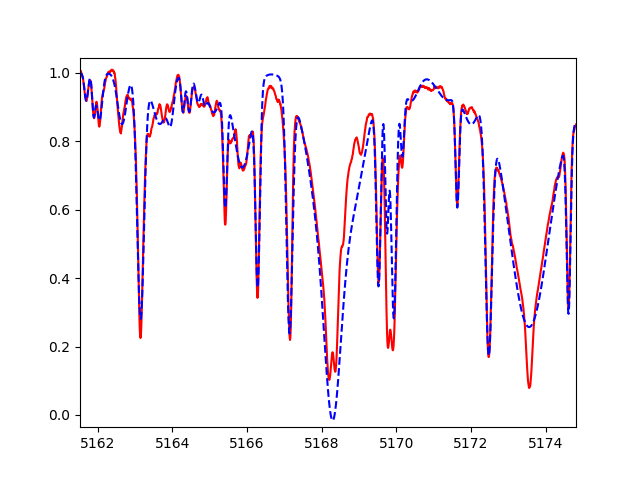

In [8]:
#What do the fits look like?
plt.plot(Template.Wavelength, Template.Flux, c='r', label='')
fitted = np.ones(len(Template.Flux))
for i in range(len(Features.Gauss_amp.values)):
    w = np.where((Template.Wavelength >= Features.Wv_lbounds[i]-2) & (Template.Wavelength <= Features.Wv_ubounds[i]+2))[0]
    fitted[w] = fitted[w] - Features.Gauss_amp.values[i]*gaussfunc(Template.Wavelength[w], Features.Gauss_mu.values[i], 
                                                                   Features.Gauss_sig.values[i])
plt.plot(Template.Wavelength, fitted, c='blue', ls='--')
plt.show()

In [9]:
#To assess which features were well-fitted with a Gaussian, we look at the mean squared-error in each set of feature
#wavelength bounds.
mTemplate = Template[(Template["Wavelength"] >= 4470) & (Template["Wavelength"] <= 8800)]
fitted = np.ones(len(mTemplate.Wavelength.values))
mFeatures = Features[(Features["MinWvl"] >= 4470) & (Features["MinWvl"] <= 8800)]
for i in range(len(mFeatures.Gauss_mu.values)):
    w = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[i]-2) & 
                 (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[i]+2))[0]
    amp = mFeatures.Gauss_amp.values[i]
    mu = mFeatures.Gauss_mu.values[i]
    sig = mFeatures.Gauss_sig.values[i]
    fitted[w] = fitted[w] - amp*gaussfunc(mTemplate.Wavelength.values[w], mu, sig)
mse = []
for i in range(len(mFeatures.Gauss_amp.values)):
    keep = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[i]) & 
                    (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[i]))[0]
    mse.append(np.mean((mTemplate.Flux.values[keep] - fitted[keep])**2))

In [10]:
np.percentile(mse, 97)

0.0020305018600406304

<IPython.core.display.Javascript object>


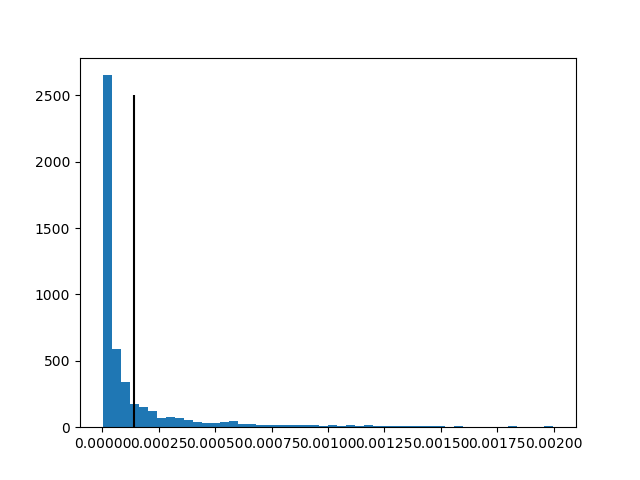

In [11]:
filt = np.where(np.array(mse) < 0.002)[0]
plt.hist(np.array(mse)[filt], bins=50)
plt.vlines(0.00014, 0, 2500)
#plt.xlim(-0.001, 0.006)
plt.show()

In [12]:
misfits = np.where(np.array(mse) > 0.00014)[0]
gdfits = np.where(np.array(mse) <= 0.00014)[0]
goodfitted = np.ones(len(fitted))
for i in gdfits:
    w = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[i]-2) & (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[i]+2))[0]
    amp = mFeatures.Gauss_amp.values[i]
    mu = mFeatures.Gauss_mu.values[i]
    sig = mFeatures.Gauss_sig.values[i]
    goodfitted[w] = goodfitted[w] - amp*gaussfunc(mTemplate.Wavelength.values[w], mu, sig)

<IPython.core.display.Javascript object>


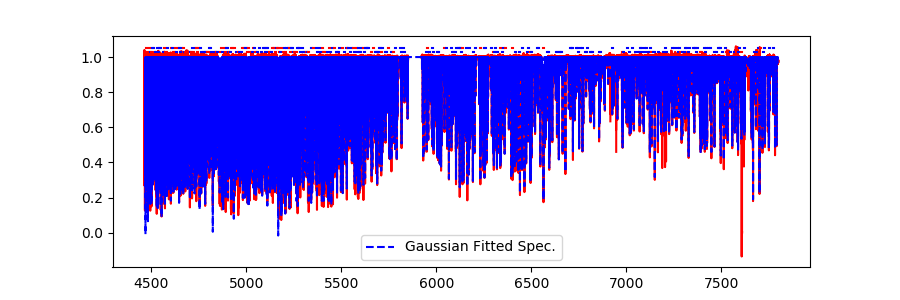

In [13]:
#Does a MSE of 0.00014 or below constitute a fit that is good?
plt.figure(figsize=(9,3))
plt.plot(Template.Wavelength, Template.Flux, c='r', label='')
#plt.plot(mTemplate.Wavelength, np.ones(len(goodfitted)) + mTemplate.Flux.values - goodfitted, c='r', label='Well Fitted Resids.')
for i in range(len(mFeatures.Gauss_mu.values)):
    if mse[i] > 0.00014:
        clr='red'
    else:
        clr='blue'
    if i%2 == 0:
        plt.plot((mFeatures.Wv_lbounds.values[i], mFeatures.Wv_ubounds.values[i]), (1.05, 1.05), c=clr)
    else:
        plt.plot((mFeatures.Wv_lbounds.values[i], mFeatures.Wv_ubounds.values[i]), (1.03, 1.03), c=clr)
plt.plot(mTemplate.Wavelength.values, fitted, c='blue', ls='--', label='Gaussian Fitted Spec.')
#plt.plot(mTemplate.Wavelength.values, goodfitted, c='green', ls='--', label='Well Fitted Spec.')
plt.legend(loc='best')
plt.show()

In [14]:
#subtract out the fit made by only including well fit features, and try refitting poorly fitted features with a sum of two
#Gaussians. If this refitting brings the mse below 0.0001 then it is considered good.
residspec = np.ones(len(goodfitted)) + mTemplate.Flux.values - goodfitted
fixed = []
fixedftrs = pd.DataFrame({"Wv_lbounds": [], "Wv_ubounds": [], "Gauss_amp": [], "Gauss_mu": [], "Gauss_sig": []})
mFeatures.set_index(np.arange(len(mFeatures.Gauss_mu.values)))
k=0
while k < len(misfits):
    ftr = misfits[k]
    w = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[ftr]) & 
                 (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[ftr]))[0]
    a2_0 = np.max([1 - np.min(mTemplate.Flux.values[w])/2,0.00001])
    mu2_0 = mTemplate.Wavelength.values[w][0] + (mTemplate.Wavelength.values[w][-1] - mTemplate.Wavelength.values[w][0])/5
    sig2_0 = np.max([(mFeatures.Wv_ubounds.values[ftr] - mFeatures.Wv_lbounds.values[ftr])/6,0.00001])
    a3_0 = np.max([1 - np.min(mTemplate.Flux.values[w])/2,0.00001])
    mu3_0 = mTemplate.Wavelength.values[w][0] + 4*(mTemplate.Wavelength.values[w][-1] - mTemplate.Wavelength.values[w][0])/5
    sig3_0 = np.max([(mFeatures.Wv_ubounds.values[ftr] - mFeatures.Wv_lbounds.values[ftr])/6,0.00001])
    try:
        pars, cov = curve_fit(gauss2func, mTemplate.Wavelength.values[w], residspec[w], 
                                  p0 = [a2_0, a3_0, mu2_0, mu3_0, sig2_0, sig3_0,],
                         bounds = ([0,0,mFeatures.Wv_ubounds.values[ftr-1],mFeatures.Wv_lbounds.values[ftr],0,0],
                                   [1,1,mFeatures.Wv_ubounds.values[ftr],mFeatures.Wv_lbounds.values[ftr+1],
                                    3*sig2_0+0.00001, 3*sig3_0+0.00001]))
    except:
        k=k+1
        continue
    newfit = gauss2func(mTemplate.Wavelength.values[w], pars[0],pars[1],pars[2],pars[3],pars[4],pars[5])
    if np.mean((residspec[w] - newfit)**2) < 0.0001:
        midpoint = mFeatures.Wv_lbounds.values[ftr] + (mFeatures.Wv_ubounds.values[ftr] - mFeatures.Wv_lbounds.values[ftr])/2
        tempdf = pd.DataFrame({"Wv_lbounds": [mFeatures.Wv_lbounds.values[ftr], midpoint], 
                                   "Wv_ubounds": [midpoint, mFeatures.Wv_ubounds.values[ftr]], 
                                   "Gauss_amp": [pars[0], pars[1]], "Gauss_mu": [pars[2], pars[3]], 
                                   "Gauss_sig": [pars[4], pars[5]]})
        fixedftrs = fixedftrs.append(tempdf)
        fixed.append(ftr)
        w = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[ftr]-2) & 
                         (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[ftr]+2))[0]
        newfit = gauss2func(mTemplate.Wavelength.values[w], pars[0],pars[1],pars[2],pars[3],pars[4],pars[5])
        residspec[w] = np.ones(len(w)) + residspec[w] - newfit

    k=k+1
remaining = [j for j in misfits if j not in fixed]
for ftr in remaining:
    w = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[ftr]) & 
                 (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[ftr]))[0]
    a2_0 = np.max([1 - np.min(mTemplate.Flux.values[w]),0.00001])
    mu2_0 = mTemplate.Wavelength.values[w][0] + (mTemplate.Wavelength.values[w][-1] - mTemplate.Wavelength.values[w][0])/2
    sig2_0 = np.max([(mFeatures.Wv_ubounds.values[ftr] - mFeatures.Wv_lbounds.values[ftr])/5,0.00001])
    try:
        pars, cov = curve_fit(gauss1func, mTemplate.Wavelength.values[w], residspec[w], p0 = [a2_0, mu2_0, sig2_0],
                         bounds = ([0,mFeatures.Wv_ubounds.values[ftr-1],0],
                                   [1,mFeatures.Wv_ubounds.values[ftr], 5*sig3_0+0.00001]))
    except:
        k=k+1
        continue
    newfit = gauss1func(mTemplate.Wavelength.values[w], pars[0],pars[1],pars[2])
    if np.mean((residspec[w] - newfit)**2) < 0.0001:
        tempdf = pd.DataFrame({"Wv_lbounds": [mFeatures.Wv_lbounds.values[ftr]], 
                                   "Wv_ubounds": [mFeatures.Wv_ubounds.values[ftr]], 
                                   "Gauss_amp": [pars[0]], "Gauss_mu": [pars[1]], 
                                   "Gauss_sig": [pars[2]]})
        fixedftrs = fixedftrs.append(tempdf)
        fixed.append(ftr)
        w = np.where((mTemplate.Wavelength.values >= mFeatures.Wv_lbounds.values[ftr]-2) & 
                         (mTemplate.Wavelength.values <= mFeatures.Wv_ubounds.values[ftr]+2))[0]
        newfit = gauss1func(mTemplate.Wavelength.values[w], pars[0],pars[1],pars[2])
        residspec[w] = np.ones(len(w)) + residspec[w] - newfit

In [15]:
#How many features were well-fitted by the end of this overall process?
len(fixed)+len(gdfits)

4577

In [16]:
#How many features are there total?
len(mFeatures.Gauss_amp.values)

4993

In [17]:
for i in range(len(fixedftrs.Gauss_amp.values)):
    w = np.where((mTemplate.Wavelength.values >= fixedftrs.Wv_lbounds.values[i]-2) & 
                 (mTemplate.Wavelength.values <= fixedftrs.Wv_ubounds.values[i]+2))[0]
    amp = fixedftrs.Gauss_amp.values[i]
    mu = fixedftrs.Gauss_mu.values[i]
    sig = fixedftrs.Gauss_sig.values[i]
    goodfitted[w] = goodfitted[w] - amp*gaussfunc(mTemplate.Wavelength.values[w], mu, sig)

<IPython.core.display.Javascript object>


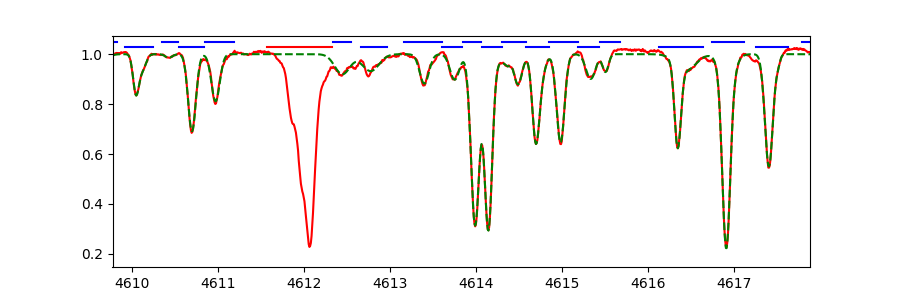

In [33]:
#What does the final fit look like?
plt.figure(figsize=(9,3))
plt.plot(mTemplate.Wavelength, mTemplate.Flux.values, c='r')
for i in range(len(mFeatures.Gauss_mu.values)):
    if mse[i] <= 0.00014 or i in fixed:
        clr='blue'
    else:
        clr='red'
    if i%2 == 0:
        plt.plot((mFeatures.Wv_lbounds.values[i], mFeatures.Wv_ubounds.values[i]), (1.05, 1.05), c=clr)
    else:
        plt.plot((mFeatures.Wv_lbounds.values[i], mFeatures.Wv_ubounds.values[i]), (1.03, 1.03), c=clr)
#plt.plot(mTemplate.Wavelength.values, fitted, c='blue', ls='--', label='Gaussian Fitted Spec.')
plt.plot(mTemplate.Wavelength.values, goodfitted, c='green', ls='--', label='Well Fitted Spec.')
plt.show()

In [34]:
fittype = np.zeros(len(mFeatures.Gauss_amp.values))
for i in range(len(fittype)):
    if i not in gdfits and i not in fixed:
        fittype[i] = 2
    elif i not in gdfits and i in fixed:
        fittype[i] = 1
mFeatures["FitType"] = fittype
mFeatures = mFeatures[["Wv_lbounds", "Wv_ubounds", "Gauss_amp", "Gauss_mu", "Gauss_sig", "FitType"]]
fixedftrs["FitType"] = np.ones(len(fixedftrs.Gauss_amp.values))
mFeatures = mFeatures[mFeatures["FitType"] == 0]
GoodFeatures = mFeatures.append(fixedftrs)

2709


In [35]:
GoodFeatures.to_csv("GoodFeatures.csv", index=False)

<IPython.core.display.Javascript object>


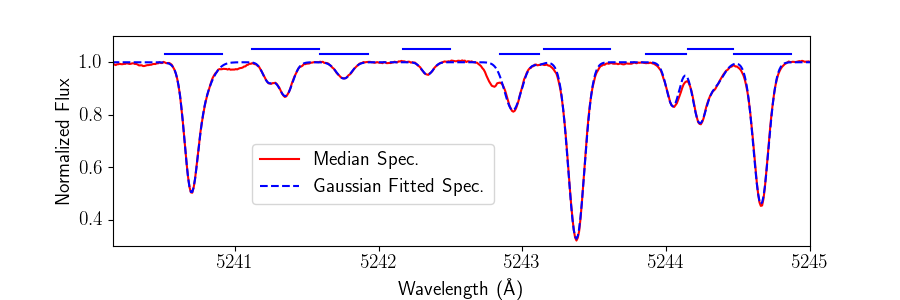

In [19]:
plt.figure(figsize=(9,3))
plt.rc('text', usetex=True)
plt.gcf().subplots_adjust(bottom=0.18)
keep = np.where((mTemplate.Wavelength.values >= 5200) & (mTemplate.Wavelength.values <= 5300))[0]
plt.plot(mTemplate.Wavelength.values[keep], mTemplate.Flux.values[keep], c='r', label='Median Spec.')
plt.plot(mTemplate.Wavelength.values, goodfitted, c='blue', ls='--', label='Gaussian Fitted Spec.')
for i in range(len(mFeatures.Gauss_mu.values)):
    if i%2 == 0:
        plt.plot((mFeatures.Wv_lbounds.values[i], mFeatures.Wv_ubounds.values[i]), (1.05, 1.05), c="blue")
    else:
        plt.plot((mFeatures.Wv_lbounds.values[i], mFeatures.Wv_ubounds.values[i]), (1.03, 1.03), c="blue")
plt.xlim(5240.15, 5245)
plt.ylim(0.3, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=(0.2, 0.2), fontsize=14)
plt.xlabel(r"Wavelength (\AA)", fontsize=14)
plt.ylabel(r"Normalized Flux", fontsize=14)
plt.savefig("Gauss_fit_spec")
plt.show()